<blockquote><h3>Simulated E-commerce Sales Analysis with Numpy, Pandas, and Matplotlib<h3></blockquote>

<h3> 📌 Introduction <h3>


A learn-by-doing mini-project with understanding how discounts, tariff taxes and pricing affect on the total sales and revenue in a simulated ecommerce environment

Goals:
- Simulate (roughly) realistic e-commerce datasets
- Analyze sales and consumers behaviour
- Interpretation of tariff effects on products 

<h3>🛠 Initialization<h3>

In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Default style
plt.style.use("fast")

#For reproductibility
np.random.seed(45)

<h3>🔨 Product & Customer Data Generation<h3>

In [310]:
#Customers - Orders - Prices (5$ - 50$)
no_customers = 130
no_products = 20 

customers = [f"C({i + 1})" for i in range(no_customers)]
products = [f"P({i + 1})" for i in range(no_products)]

#Prices are randomly set by using np.random.uniform()
prices = np.random.uniform(5, 50, size = 20)
prices = np.round(prices, 2)

#Discount prices (20 - 35% for abundant datasets), but only one half of products are applicable
discount_flags = np.zeros(len(products))
mask = np.random.rand(len(products)) <= 0.5

#Tariff rates (10% as base taxes, added by 16 → 32% if the total revenues are doubted to have "inappropriate imports")

discount_flags[mask] = np.random.uniform(0.2, 0.35, size = np.sum(mask))

<h3>🛍️ Order Simulation - Standard Raise<h3>

In [313]:
#Order simulation (around 1500)

#Assuming customer buy 1 - 2 products on average, such cases where the products are rised to 3 → 5
no_orders = 1500
#Standard raise prices of a product if its sales are relatively good
std_raise = 150

#Order Dataframe
orders = {
    "customer_id" : np.random.choice(customers, no_orders),
    "product_id" : np.random.choice(products, no_orders),
    "quantity" : np.random.choice([1,2,3,4,5], size = no_orders, p = [0.41, 0.31, 0.12, 0.12, 0.04]),
    "order_day" : np.random.randint(1, 31, size = no_orders)
}

#Days usually refer to how many orders of specific products are being made in that time. E.g: Day 17, Customer No.17 bought 2 items of product no. 7
orders_df = pd.DataFrame(orders)

#Simple approach of Data Cleaning process (filtering out NaN, 0)
orders_df = orders_df[orders_df["quantity"] > 0]

<h3>📦 Products - Orders Dataframe<h3>

In [316]:
#Product Dataframe
product_df = pd.DataFrame({
    "product_id" : products,
    "price" : prices,
    "discounted" : discount_flags
})

#Revenue dataframe
orders_df = orders_df.merge(product_df, on = "product_id")
orders_df["total_revenue"] = round(orders_df["quantity"] * orders_df["price"], 2)
 
#Total sales per product
sales_summary = orders_df.groupby("product_id").agg(total_sales = ("quantity", "sum"), total_revenue = ("total_revenue", "sum")).reset_index()

#Merge back the product_sales
product_sales_df = product_df.merge(sales_summary, on = "product_id", how = "left").fillna(0)

<h3>💰 Price Simulation<h3>

Price Simulation Strategy:
- If the product gets discount and its sales are going well, leads to scarcity and the price will increase from 10 → 25%
- The product although being discounted, the sales are relatively small → Continue to drop the price within 20 → 35%
- The product without discounts may increase gradually from 5% → 20%

In [320]:
#Price adjustment simulation: If get discounted, the sales is likely to increase → Scarcity. 
#If not get discounted, increase the price → Either abandoned or at some point consumers somehow realize its importance and the sales eventually increases while with discounts, the product cannot make impression  
def price_simulation(quantity, price, discounted):
    if discounted > 0:
        if quantity >= std_raise:
            #Scarcity leads to a surge in needs → Increased price
            return round(price * (1 + np.random.uniform(0.1, 0.25)), 2)
        else:
            #A product which is less well-known will be boosted with discounts
            return round(price * (1 - discounted), 2)
    else:
        #Non-discounted items slightly increase due to the hot-choice
        return round(price * (1 + np.random.uniform(0.05, 0.2)), 2)

#Round total sales into 2-decimal points → For readability
product_sales_df["adjusted_price"] = product_sales_df.apply(lambda row : round(price_simulation(row["total_sales"], row["price"], row["discounted"]), 2), axis = 1)

Visualisation : Top-10 Selling Products

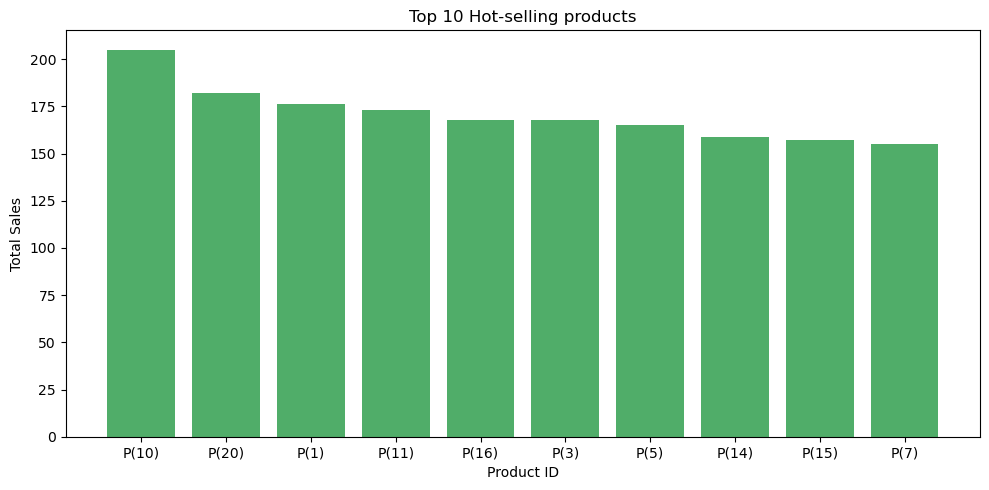

In [323]:
#Top-10 selling products
top_10 = sales_summary.sort_values("total_sales", ascending = False).head(10) 

plt.figure(figsize = (10, 5))
plt.bar(top_10["product_id"], top_10["total_sales"], color = "#50ad69")
plt.title("Top 10 Hot-selling products")
plt.xlabel("Product ID")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

<h3>📉 Price analysis change (Default price V.S Discounted price)<h3>

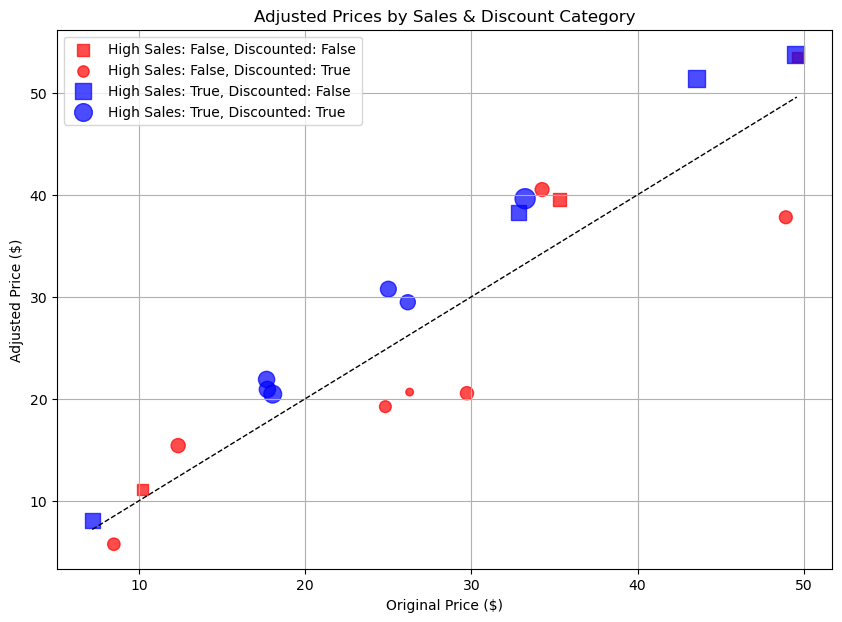

In [326]:
# Create a boolean column for discount presence (True if discounted > 0)
product_sales_df["discounted_bool"] = product_sales_df["discounted"] > 0

# Create the high_sales column: True if total_sales is above the median
product_sales_df["high_sales"] = product_sales_df["total_sales"] > product_sales_df["total_sales"].median()

# Calculate the min and max of total_sales to scale sizes
min_total = product_sales_df["total_sales"].min()
max_total = product_sales_df["total_sales"].max()

# Set up the figure
plt.figure(figsize=(10,7))

# Group the DataFrame by high_sales (boolean) and discounted_bool (boolean)
groups = product_sales_df.groupby(["high_sales", "discounted_bool"])

for (high_sales, discounted_bool), group in groups:
    # Set marker style based on whether the product is discounted
    marker = 'o' if discounted_bool else 's'
    # Set color based on high_sales (blue for True, red for False)
    color = 'blue' if high_sales else 'red'
    # Scale sizes: normalize total_sales to range [20, 200]
    sizes = 30 + (group["total_sales"] - min_total) / (max_total - min_total) * (200 - 20)
    # Create a label for the legend
    label = f"High Sales: {high_sales}, Discounted: {discounted_bool}"
    plt.scatter(group["price"],
                group["adjusted_price"],
                s=sizes,
                marker=marker,
                color=color,
                alpha=0.7,
                label=label)

# Plot a reference 45-degree line (line of parity)
price_min = product_sales_df["price"].min()
price_max = product_sales_df["price"].max()
plt.plot([price_min, price_max],
         [price_min, price_max],
         "k--", lw=1)

# Set plot title and axis labels
plt.title("Adjusted Prices by Sales & Discount Category")
plt.xlabel("Original Price ($)")
plt.ylabel("Adjusted Price ($)")
plt.grid(True)

# Create a legend (avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


<h3>🧾 Return list of the total revenue - sales of 20 products<h3>

In [329]:
product_sales_df.style.format({"discounted" : "{:.0%}", "price" : "{:.2f}", "total_revenue" : "{:.2f}", "adjusted_price" : "{:.2f}"})

,product_id,price,discounted,total_sales,total_revenue,adjusted_price,discounted_bool,high_sales
0,P(1),49.51,0%,176,8713.76,53.78,False,True
1,P(2),29.73,31%,145,4310.85,20.54,True,False
2,P(3),17.67,25%,168,2968.56,21.89,True,True
3,P(4),8.48,32%,140,1187.20,5.73,True,False
4,P(5),25.00,27%,165,4125.00,30.74,True,True
5,P(6),26.28,21%,115,3022.20,20.65,True,False
6,P(7),7.18,0%,155,1112.90,8.08,False,True
7,P(8),12.35,33%,152,1877.20,15.40,True,False
8,P(9),10.22,0%,133,1359.26,11.13,False,False
9,P(10),33.23,31%,205,6812.15,39.61,True,True


<h3> 📋 External factors influence on overall sales (prices with discounts applied) <h3>

Tariff Rate Rules
- Base Tariff: 10% (for all products by default)
- Additional Tariff (Suspicious Origin): +16% to +32%
- Apply if total_revenue is flagged (doubted origin or no certificates)

In [333]:
product_sales_df["suspicious_origin"] = np.random.choice([True, False], size = len(products), p = [0.4, 0.6])

product_sales_df["tariff_rate"] = 10

product_sales_df["tariff_rate"] = product_sales_df["tariff_rate"].round(2).astype(float)

product_sales_df.loc[product_sales_df["suspicious_origin"], "tariff_rate"] += np.random.uniform(16, 32, size = product_sales_df["suspicious_origin"].sum())

#Calculate tariff amount and fixed-price with tariff
product_sales_df["tariff_amount"] = product_sales_df["adjusted_price"] * (product_sales_df["tariff_rate"] / 100)
product_sales_df["fixed-price_with_tariff"] = product_sales_df["adjusted_price"] + product_sales_df["tariff_amount"]

#Revenue with tariff
product_sales_df["tariff_applied_revenue"] = product_sales_df["fixed-price_with_tariff"] * product_sales_df["total_sales"]

<h3> 📊 Visualisation of tariff influence on overall revenues <h3>

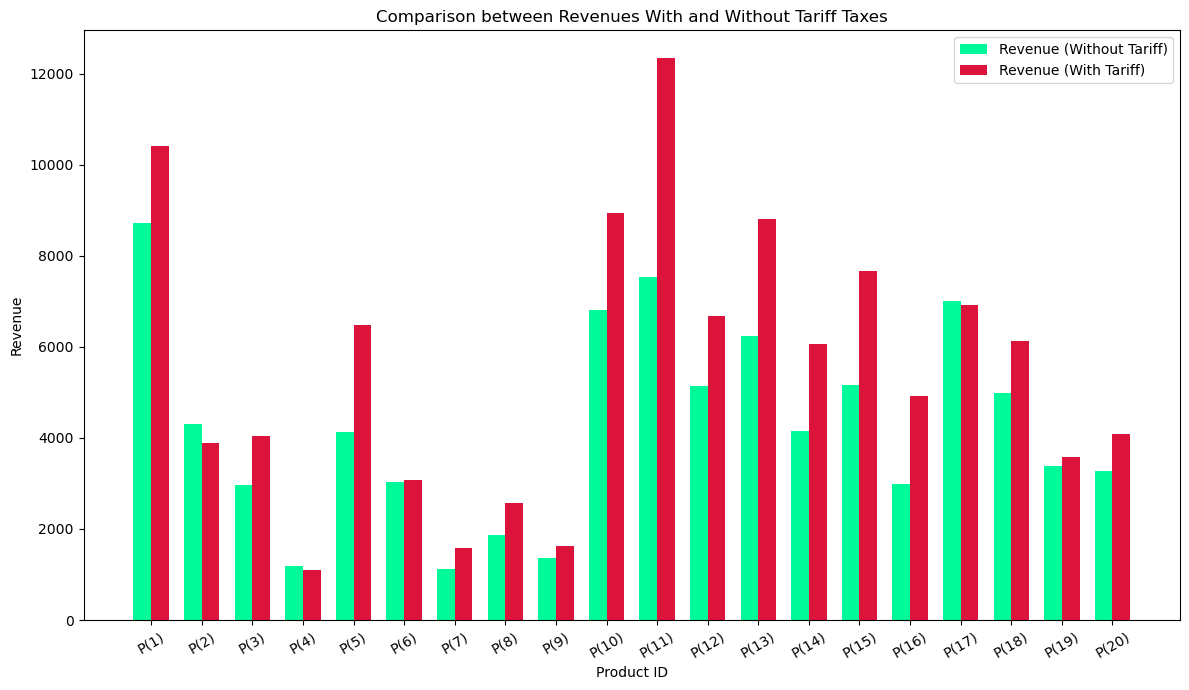

In [336]:
x = np.arange(len(product_sales_df))
width = 0.35

fig, ax = plt.subplots(figsize = (12, 7))
bar1 = ax.bar(x - width/2, product_sales_df["total_revenue"], width, label = "Revenue (Without Tariff)", color = "mediumspringgreen")
bar1 = ax.bar(x + width/2, product_sales_df["tariff_applied_revenue"], width, label = "Revenue (With Tariff)", color = "crimson")

ax.set_xlabel("Product ID")
ax.set_ylabel("Revenue")
ax.set_title("Comparison between Revenues With and Without Tariff Taxes")
ax.set_xticks(x)
ax.set_xticklabels(product_df["product_id"], rotation = 30)
ax.legend()

plt.tight_layout()
plt.show()

<h3> 📋 Summary Table <h3>

In [339]:
#Summary Table
summary_df = pd.DataFrame({
    "Product": product_df["product_id"],
    "Total Sales": product_sales_df["total_sales"],
    "Adjusted Price": product_sales_df["adjusted_price"],
    "Fixed-price With Tariff": product_sales_df["fixed-price_with_tariff"].round(2),
    "Suspicious Origin": product_sales_df["suspicious_origin"],
    "Tariff Rate": (product_sales_df["tariff_rate"].apply(lambda x: f"{x/100:.2%}")),
    "Revenue Without Tariff": product_sales_df["total_revenue"].round(2),
    "Revenue With Tariff": product_sales_df["tariff_applied_revenue"].round(2)
})

summary_df["% Change Due to Tariff"] = ((summary_df["Revenue With Tariff"] - summary_df["Revenue Without Tariff"]) / summary_df["Revenue Without Tariff"] * 100).round(2)
summary_df

,Product,Total Sales,Adjusted Price,Fixed-price With Tariff,Suspicious Origin,Tariff Rate,Revenue Without Tariff,Revenue With Tariff,% Change Due to Tariff
0,P(1),176,53.78,59.16,False,10.00%,8713.76,10411.81,19.49
1,P(2),145,20.54,26.84,True,30.65%,4310.85,3891.29,-9.73
2,P(3),168,21.89,24.08,False,10.00%,2968.56,4045.27,36.27
3,P(4),140,5.73,7.84,True,36.74%,1187.20,1096.95,-7.60
4,P(5),165,30.74,39.32,True,27.90%,4125.00,6487.39,57.27
5,P(6),115,20.65,26.69,True,29.23%,3022.20,3068.88,1.54
6,P(7),155,8.08,10.24,True,26.78%,1112.90,1587.79,42.67
7,P(8),152,15.40,16.94,False,10.00%,1877.20,2574.88,37.17
8,P(9),133,11.13,12.24,False,10.00%,1359.26,1628.32,19.79
9,P(10),205,39.61,43.57,False,10.00%,6812.15,8932.06,31.12


In [211]:
summary_df.to_csv("ecommerce_summary.csv", index=False)

### 🧠 Inconclusion

This analysis gives valuable insights on the effects of internal / external factors on overall sales of e-commerece products. 

- Discount products, though stimulates the consumption needs, can lead to scarcity
- Tariff taxes widely spreads out the increase of price, especially those are tagged as suspicious origin
- Pricing adjustments are made based on sales performance → simulate consumer behaviour towards prices and decision-making

### 🛠️ Further refinements

- Price elasticity of demand
- Enhanced randomness through Probability distributions (Poisson, Binomal,...)
- Odd cases such policy and regulation are accountable
- Since this is EDA-groundwork, no major features will be added.

### 📋 Notes

- Bear in mind that all of statistics is generated through random functions and served for educational purpose only.
- Any suggestions, further improvements are meaningful at this time.